<a href="https://colab.research.google.com/github/nayoonchoi00/PyTorch-DL/blob/main/05_DNN_%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98%EA%B8%B0_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

### 내장 데이터셋 로드

- `FashionMNIST` 데이터셋 로드하는 예제


- `root`: 데이터셋을 다운로드 받을 경로(폴더) 지정.
- `train`: `True`로 설정된 경우 `train` 데이터셋에서 로드하며, `False`인 경우 `test` 데이터셋에서 로드
- `download`: `True`로 설정된 경우, 인터넷으로부터 데이터셋을 다운로드 받아 지정된 `root` 디렉토리에 다운로드
- `transform`: 이미지 `transform` 적용


In [2]:
# Image Transform 정의
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [3]:
# train(학습용) 데이터셋 로드
train = datasets.FashionMNIST(
    root="data",
    train=True,  # set True
    download=True,  # 다운로드
    transform=transform,  # transform 적용. (0~1 로 정규화)
)

100%|██████████| 26421880/26421880 [00:01<00:00, 13374254.15it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212217.74it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3198327.23it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5059108.95it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# test(학습용) 데이터셋 로드
test = datasets.FashionMNIST(
    root="data",
    train=False,  # set to False
    download=True,  # 다운로드
    transform=transform,  # transform 적용. (0~1 로 정규화)
)

`FashionMNIST` 데이터셋 시각화

- 총 10개의 카테고리로 구성되어 있으며, `Label`은 아래 코드에서 `labels_map`에 정의되어 있습니다.
- 출처: [zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)


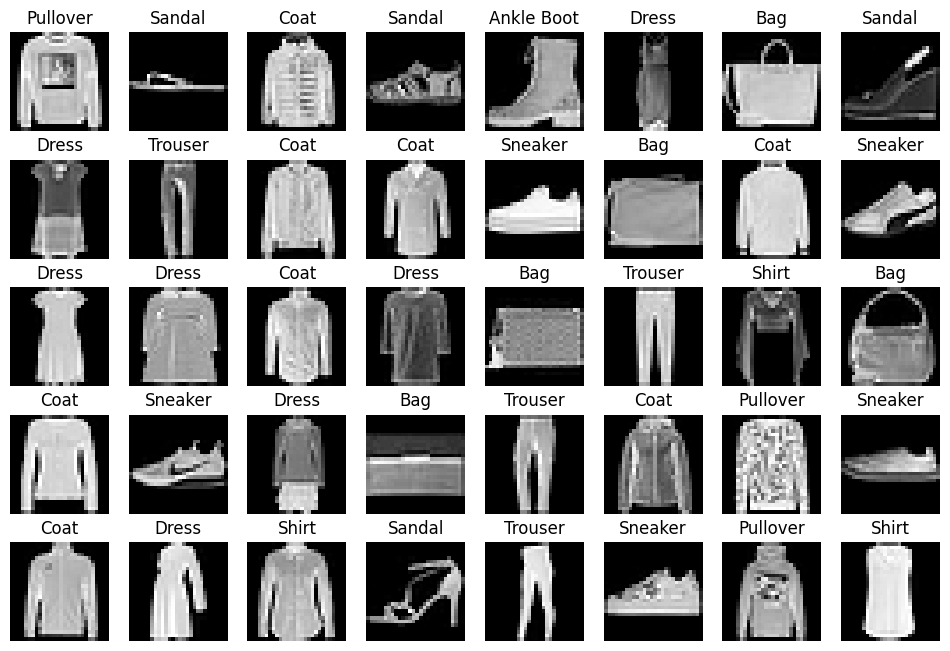

In [5]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap="gray")
plt.show()

### torch.utils.data.DataLoader로 데이터셋 로더 구성


In [6]:
batch_size = 32  # batch_size 지정
num_workers = 8  # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

In [7]:
train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False, num_workers=num_workers
)

## 모델 생성


In [9]:
if torch.backends.mps.is_built():
    # mac os mps 지원 체크
    device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")
else:
    # cuda 사용 가능한지 체크
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        # 마지막 출력층의 Neuron은 Class 개수로 설정
        self.output = nn.Linear(32, num_classes)

    def forward(self, x):
        # (B, 1, 28, 28) -> (B, 28*28)
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x

In [11]:
# 모델 생성
model = Net(num_classes=10)

# 모델을 device 에 올립니다. (cuda:0 혹은 cpu)
model.to(device)
model

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

## 손실함수 / 옵티마이저 정의


In [12]:
# Cross Entropy Loss 오차 정의
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저 설정: model.paramters()와 learning_rate 설정
optimizer = optim.Adam(model.parameters(), lr=0.005)

## 훈련


In [13]:
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    final_loss = 0
    running_acc = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # gradient 초기화
        optimizer.zero_grad()
        # forward pass
        y_hat = model(x)
        # loss 계산
        loss = loss_fn(y_hat, y)
        # backward pass
        loss.backward()
        # weight update
        optimizer.step()
        final_loss += loss.item()
        running_acc += y_hat.argmax(dim=1).eq(y).sum().item() / len(y)
    final_loss /= len(train_loader)
    running_acc /= len(train_loader)
    return final_loss, running_acc


def evaluate(model, test_loader, loss_fn, device):
    # 모델을 평가 모드로 설정
    model.eval()
    final_loss = 0
    running_acc = 0
    with torch.no_grad():

        for x, y in test_loader:
            # 데이터를 device에 올립니다.
            x, y = x.to(device), y.to(device)
            # forward pass
            y_hat = model(x)
            # loss 계산
            loss = loss_fn(y_hat, y)
            # loss 누적
            final_loss += loss.item()
            running_acc += y_hat.argmax(dim=1).eq(y).sum().item() / len(y)
    final_loss /= len(test_loader)
    running_acc /= len(test_loader)
    return final_loss, running_acc

In [14]:
# 최대 반복 횟수 정의
num_epoch = 20

# loss 기록하기 위한 list 정의
losses = []
val_losses = []

MIN_LOSS = 9999999999.0

# 가중치를 저장할 파일명 정의
STATE_DICT_PATH = "mymodel.pth"

for epoch in range(num_epoch):
    loss, acc = train(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = evaluate(model, test_loader, loss_fn, device)
    losses.append(loss)
    val_losses.append(val_loss)
    if val_loss < MIN_LOSS:
        print(f"{epoch:05d} [INFO] Model saved... {MIN_LOSS:.5f} ===> {val_loss:.5f}")
        MIN_LOSS = val_loss
        torch.save(model.state_dict(), STATE_DICT_PATH)

    print(
        f"[{epoch:03d}] loss: {loss:.5f} acc: {acc:.5f} val_loss: {val_loss:.5f} val_acc: {val_acc:.5f}"
    )

00000 [INFO] Model saved... 9999999999.00000 ===> 0.48905
[000] loss: 0.52589 acc: 0.80850 val_loss: 0.48905 val_acc: 0.81869
00001 [INFO] Model saved... 0.48905 ===> 0.43043
[001] loss: 0.40660 acc: 0.85422 val_loss: 0.43043 val_acc: 0.84625
00002 [INFO] Model saved... 0.43043 ===> 0.39849
[002] loss: 0.37182 acc: 0.86598 val_loss: 0.39849 val_acc: 0.85903
00003 [INFO] Model saved... 0.39849 ===> 0.39231
[003] loss: 0.34969 acc: 0.87332 val_loss: 0.39231 val_acc: 0.86172
00004 [INFO] Model saved... 0.39231 ===> 0.38582
[004] loss: 0.34581 acc: 0.87605 val_loss: 0.38582 val_acc: 0.86332
[005] loss: 0.33232 acc: 0.88128 val_loss: 0.38662 val_acc: 0.86951
00006 [INFO] Model saved... 0.38582 ===> 0.38037
[006] loss: 0.32085 acc: 0.88443 val_loss: 0.38037 val_acc: 0.86681
00007 [INFO] Model saved... 0.38037 ===> 0.37736
[007] loss: 0.31991 acc: 0.88460 val_loss: 0.37736 val_acc: 0.87141
[008] loss: 0.30428 acc: 0.89050 val_loss: 0.38704 val_acc: 0.86811
00009 [INFO] Model saved... 0.37736 

KeyboardInterrupt: 

## 저장한 가중치 로드


In [15]:
model.load_state_dict(torch.load(STATE_DICT_PATH))

<ipython-input-15-05479f6819bb>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(STATE_DICT_PATH))


<All keys matched successfully>

## 최종 성능 평가


In [16]:
# 검증모드 진입
model.eval()
# loss 초기화
running_loss = 0
# 정확도 계산
running_acc = 0

with torch.no_grad():
    for (
        x,
        y,
    ) in test_loader:
        x, y = x.to(device), y.to(device)

        output = model(x)

        running_loss += loss
        running_acc += output.argmax(dim=1).eq(y).sum().item() / len(y)

    loss = running_loss / len(test_loader)
    acc = running_acc / len(test_loader)

# 최종 훈련 결과확인
print(f"Loss: {loss:.5f}, Accuracy: {acc:.5f}")

Loss: 0.25398, Accuracy: 0.87370
